Creates a CSV (comma separated values) file with values for the bounding boxes of the license plates

In [1]:
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
import os
import cv2
#finds a tag in another tag
def search_tag(root, attribute):
    for child in root:
        if str(child.tag) == attribute:
            return child
        else:
            if search_tag(child, attribute) != None:
                return search_tag(child, attribute)

#returns the text of a tag
def get_tag(file_path, attribute):
    tree = ET.parse(file_path)
    root = tree.getroot()
    ele = search_tag(root, attribute)
    return ele.text

#Creates a csv file with all of the pictures data
def create_csv(xml_location, csv_location):
    labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
    for root, dirs, files in os.walk(xml_location):
        for filename in files:
            if filename.endswith('.xml'):
                file_path = os.path.join(root, filename)
                tree = ET.parse(file_path)
                root_xml = tree.getroot()
                objects = root_xml.findall("object")
                if len(objects) > 1:
                    for ob in objects:
                        xmin = int(search_tag(ob, 'xmin').text)
                        xmax = int(search_tag(ob, 'xmax').text)
                        ymin = int(search_tag(ob, 'ymin').text)
                        ymax = int(search_tag(ob, 'ymax').text)
                        labels_dict['filepath'].append(filename)
                        labels_dict['xmin'].append(xmin)
                        labels_dict['xmax'].append(xmax)
                        labels_dict['ymin'].append(ymin)
                        labels_dict['ymax'].append(ymax)
                else:
                    xmin = int(get_tag(file_path, "xmin"))
                    xmax = int(get_tag(file_path, "xmax"))
                    ymin = int(get_tag(file_path, "ymin"))
                    ymax = int(get_tag(file_path, "ymax"))
                    labels_dict['filepath'].append(filename)
                    labels_dict['xmin'].append(xmin)
                    labels_dict['xmax'].append(xmax)
                    labels_dict['ymin'].append(ymin)
                    labels_dict['ymax'].append(ymax)

    df = pd.DataFrame(labels_dict)
    df.to_csv(csv_location,index=False)

create_csv(r"C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Labelling\plates", r"C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Labelling\plates.csv")

,filepath,xmin,xmax,ymin,ymax
0,1.xml,1181,1431,634,787
1,10.xml,197,288,188,209
2,100.xml,250,493,367,425
3,101.xml,243,403,222,270
4,102.xml,284,472,454,534


In [ ]:
import pandas as pd
df = pd.read_csv(r"C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Labelling\plates.csv")
filename = df['filepath']
filename
df.head()

Verify the image, output and bounding box 

In [3]:
import cv2
test_image_path = r"C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Labelling\plates\1.jpg"
#test_image_path

#N1.xml,1093,1396,645,727
image = cv2.imread(test_image_path)
cv2.namedWindow("test image", cv2.WINDOW_NORMAL)
cv2.rectangle(image, (1093,645), (1396,727),(0,255,0),3)
cv2.imshow("test image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Data Processing

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

labels = df.values
data = []
output = []
image_dir = r"D:\download\Plate-Recognition-App\Labelling\plates"
for i in range(len(labels)):
    xml_filename,xmin,xmax,ymin,ymax = labels[i]
    image = os.path.join(image_dir, xml_filename.replace('.xml','.jpg'))
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape

    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # normalization
    
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # normalized output
    data.append(norm_load_image_arr)
    output.append(label_norm)

X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)
#X.shape,y.shape
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)


<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1948820>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1948820>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1948820>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1948820>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1948820>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1948820>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1948820>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29EB9600F40>
<PIL.Image.Image image mode=RGB size=224x224 at 0x29ED1

((318, 224, 224, 3), (80, 224, 224, 3), (318, 4), (80, 4))

Deep Learning Model

In [6]:
import tensorflow as tf


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(224, (3,3), activation='relu', input_shape=(224,224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(448, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Conv2D(448, (3,3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(448, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 224)     6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 224)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 448)     903616    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 448)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 448)       1806784   
                                                                 
 flatten (Flatten)           (None, 1211392)           0

Model Training

In [7]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'weights.best.wow.hdf5', verbose = 2, save_best_only = True)
# If score doesn't improve during patience=20 epochs, stop learning
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=2)
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=300, validation_data=(x_test,y_test),callbacks = [checkpointer, estopping])

Epoch 1/100
32/32 [==============================] - 272s 8s/step - loss: 0.0460 - val_loss: 0.0208
Epoch 2/100
32/32 [==============================] - 289s 9s/step - loss: 0.0119 - val_loss: 0.0117
Epoch 3/100
32/32 [==============================] - 273s 9s/step - loss: 0.0052 - val_loss: 0.0102
Epoch 4/100
32/32 [==============================] - 253s 8s/step - loss: 0.0023 - val_loss: 0.0112
Epoch 5/100
32/32 [==============================] - 259s 8s/step - loss: 0.0013 - val_loss: 0.0101
Epoch 6/100
32/32 [==============================] - 277s 9s/step - loss: 8.6982e-04 - val_loss: 0.0102
Epoch 7/100
32/32 [==============================] - 269s 8s/step - loss: 9.0539e-04 - val_loss: 0.0100
Epoch 8/100
32/32 [==============================] - 257s 8s/step - loss: 8.4511e-04 - val_loss: 0.0098
Epoch 9/100
32/32 [==============================] - 255s 8s/step - loss: 6.9191e-04 - val_loss: 0.0098
Epoch 10/100
32/32 [==============================] - 258s 8s/step - loss: 7.3416e-0

In [8]:
model.save(r"C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\object_detection_5")

INFO:tensorflow:Assets written to: C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\object_detection_3\assets


Making Predictions

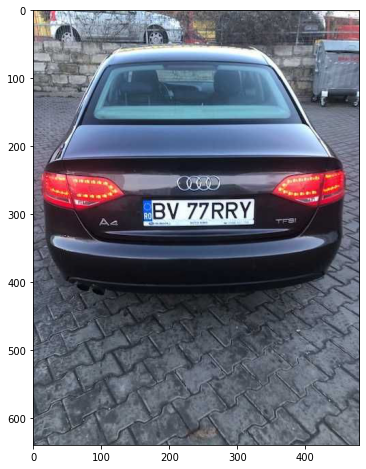

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

model = tf.keras.models.load_model(r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\object_detection_3')
path = r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Labelling\plates\369.jpg'
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # convert into array and get the normalized output
h,w,d = image.shape
plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()


[[0.30067292 0.7048433  0.41312736 0.5107812 ]]
[480 480 640 640]
[[144.32300091 338.3247757  264.40151215 326.89998627]]
[[144 338 264 326]]
(144, 264) (338, 326)


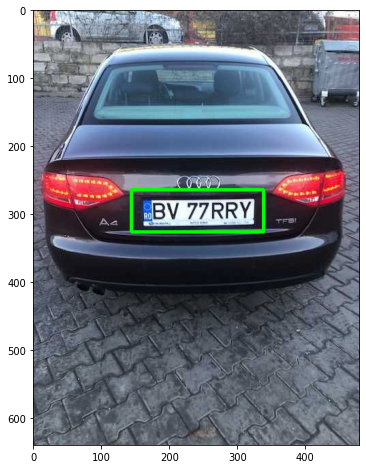

In [2]:
#image array shape (224, 224, 3)
test_arr = image_arr_224.reshape(1,224,224,3)
coords = model.predict(test_arr) #[[0.3962295  0.60310304 0.64686245 0.72772896]] [[0.37943992 0.64521426 0.64613414 0.7373784 ]]
denorm = np.array([w,w,h,h]) #[541 541 423 423] [541 541 423 423]
coords = coords * denorm #[[214.3601625  326.27874553 273.62281519 307.82935131]] [[205.27699682 349.06091446 273.31474042 311.911071  ]]
coords = coords.astype(np.int32) #[[214 326 273 307]] [[205 349 273 311]]

#bounding box
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)
cv2.rectangle(image,pt1,pt2,(0,255,0),3)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

Optical Character Recognition (OCR)

Running the model on the plates in order to measure accuracy


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
#import pytesseract as pt
import os

model = tf.keras.models.load_model(r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\object_detection_3')
dir_path = r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Labelling\plates'
for root, dirs, files in os.walk(dir_path):
    for filename in files:
        if filename.endswith('.jpg'):
            try:
                file_path = os.path.join(root, filename)
                image = load_img(file_path) # PIL object
                image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
                image1 = load_img(file_path,target_size=(224,224))
                image_arr_224 = img_to_array(image1)/255.0  # convert into array and get the normalized output
                h,w,d = image.shape
                test_arr = image_arr_224.reshape(1,224,224,3)
                coords = model.predict(test_arr) #[[0.3962295  0.60310304 0.64686245 0.72772896]] [[0.37943992 0.64521426 0.64613414 0.7373784 ]]
                denorm = np.array([w,w,h,h]) #[541 541 423 423] [541 541 423 423]
                coords = coords * denorm #[[214.3601625  326.27874553 273.62281519 307.82935131]] [[205.27699682 349.06091446 273.31474042 311.911071  ]]
                coords = coords.astype(np.int32) #[[214 326 273 307]] [[205 349 273 311]]
                xmin, xmax,ymin,ymax = coords[0]
                pt1 =(xmin,ymin)
                pt2 =(xmax,ymax)
                cv2.rectangle(image,pt1,pt2,(0,255,0),3)

                img=np.array(load_img(file_path))
                xmin, xmax, ymin, ymax = coords[0]
                #crop the bounding box -region of interest
                roi= img [ymin:ymax, xmin:xmax]

                plt.figure(figsize=(10,8))
                plt.imshow(roi)
                plt.savefig(os.path.join(r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\test', filename))
            except:
                print(filename)

Extracting the images showing the region of interest (Roi) in order to use them for training a new network capable of recognizing text. The region of interest is chosen based on the coordinates extracted from the xml tree of each image.

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
from Labelling import edit_xml

dir_path = r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Labelling\plates'
for root, dirs, files in os.walk(dir_path):
    for filename in files:
        if filename.endswith('.jpg'):
            
            file_path = os.path.join(root, filename)
            image = load_img(file_path) # PIL object
            image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
            xml_path = os.path.join(root, filename.replace('jpg', 'xml'))
            xmin = int(edit_xml.get_tag(xml_path, 'xmin'))
            xmax = int(edit_xml.get_tag(xml_path, 'xmax'))
            ymin = int(edit_xml.get_tag(xml_path, 'ymin'))
            ymax = int(edit_xml.get_tag(xml_path, 'ymax'))
            pt1 =(xmin,ymin)
            pt2 =(xmax,ymax)
            cv2.rectangle(image,pt1,pt2,(0,255,0),3)

            img=np.array(load_img(file_path))
            #crop the bounding box -region of interest
            roi= img [ymin:ymax, xmin:xmax]

            #plt.figure(figsize=(10,8))
            #plt.axis('off')
            #plt.imshow(roi)
            #plt.savefig(os.path.join(r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\Roi', filename), bbox_inches='tight', pad_inches=0)

OCR model 

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras

data = []
labels = []
labels_dic = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'Q': 10,
    'W': 11,
    'E': 12,
    'R': 13,
    'T': 14,
    'Y': 15,
    'U': 16,
    'I': 17,
    'O': 18,
    'P': 19,
    'A': 20,
    'S': 21,
    'D': 22,
    'F': 23,
    'G': 24,
    'H': 25,
    'J': 26,
    'K': 27,
    'L': 28,
    'Z': 29,
    'X': 30,
    'C': 31,
    'V': 32,
    'B': 33,
    'N': 34,
    'M': 35
}
dir_path = r'D:\download\Plate-Recognition-App\alphabet\0'
for filename in os.listdir(dir_path):
    image = load_img(os.path.join(dir_path, filename), color_mode="grayscale")
    img_arr = img_to_array(image)
    img_arr = cv2.resize(img_arr, (32, 32)) 
    print(img_arr.shape)
    label = filename.split('_')[1]
    label = label.replace('.jpg', '')
    data.append(img_arr)
    encode_label = np.zeros((36,))
    encode_label[labels_dic[label]] = 1
    labels.append(encode_label)
    

    
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels, dtype="int")
data /= 255.0
print(data[0].shape)
INPUT_SHAPE = (32, 32, 1)

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, stratify=None)


Shaping the model that recognizes characters

In [ ]:
def top_3_categorical_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

def CNN_model(activation = 'softmax', loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', top_3_categorical_accuracy]):
    
    model =  keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = INPUT_SHAPE))
    model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
    model.add(keras.layers.Conv2D(128, (4, 4), activation = 'relu'))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation = 'relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(36, activation = activation))
    
    # Compile the model
    model.compile(loss = loss,optimizer = optimizer, metrics = metrics)
    
    return model

cnn_model = CNN_model()

# Save weights only for best model
checkpointer = keras.callbacks.ModelCheckpoint(filepath = 'weights.best.letters.hdf5', verbose = 2, save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_loss'patience=10, verbose=2, factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=2)

Training and evaluating the model

In [ ]:

# Training
history = cnn_model.fit(trainX, trainY,batch_size = 64,epochs = 100,verbose = 1,validation_data = (testX, testY),callbacks = [checkpointer, lr_reduction, estopping])
cnn_model.load_weights('weights.best.letters.hdf5')
cnn_model.evaluate(testX, testY)

Testing the OCR model

In [ ]:
import imutils
labels_dic = {
                0: '0',
                1: '1',
                2: '2', 
                3: '3', 
                4: '4', 
                5: '5', 
                6: '6', 
                7: '7', 
                8: '8', 
                9: '9', 
                10: 'Q', 
                11: 'W', 
                12: 'E', 
                13: 'R', 
                14: 'T', 
                15: 'Y', 
                16: 'U', 
                17: 'I', 
                18: 'O', 
                19: 'P', 
                20: 'A', 
                21: 'S', 
                22: 'D', 
                23: 'F', 
                24: 'G', 
                25: 'H', 
                26: 'J', 
                27: 'K', 
                28: 'L', 
                29: 'Z', 
                30: 'X', 
                31: 'C', 
                32: 'V', 
                33: 'B', 
                34: 'N', 
                35: 'M'
            }

model_ocr = CNN_model()
model_ocr.load_weights(r'C:\Users\bogda\Documents\GitHub\Plate-Recognition-App\OCR\weights.best.letters.hdf5')

I = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
xmin, xmax, ymin, ymax = coords[0]
I = I[ymin:ymax, xmin:xmax]

_,I = cv2.threshold(I,0.,255.,cv2.THRESH_OTSU)
I = cv2.bitwise_not(I)

_,labels,stats,centroid = cv2.connectedComponentsWithStats(I)

result = np.zeros((I.shape[0],I.shape[1],3),np.uint8)
counters = []
for i in range(0,labels.max()+1):
    mask = cv2.compare(labels,i,cv2.CMP_EQ)

    ctrs,_ = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    
    for cnt in ctrs:
        (x, y, w, h) = cv2.boundingRect(cnt)
        if (w >= 10 and w <= 150) and (h >= 40 and h <= 120) and (h > w):
            counters.append((x, y, w, h))
counters.sort(key = lambda c: c[0])
number = ''
for x, y, w, h in counters:
    roi = I[y:y + h, x:x + w]
    thresh = cv2.threshold(roi, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    (tH, tW) = thresh.shape

    if tW > tH:
        thresh = imutils.resize(thresh, width=32)
    else:
        thresh = imutils.resize(thresh, height=32)

    (tH, tW) = thresh.shape
    dX = int(max(0, 32 - tW) / 2.0)
    dY = int(max(0, 32 - tH) / 2.0)

    padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
        left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
        value=(255, 255, 255))
    img_arr = cv2.resize(padded, (32, 32))
    img_arr = img_arr.reshape(1, 32, 32, 1)
    preds = model.predict(img_arr)
    i = np.argmax(preds)
    number += labels_dic[i] 
number
